In [1]:
import numpy as np
import cmath
import matplotlib.pyplot as plt
from scipy.misc import derivative
from scipy import optimize

from scipy.optimize import Bounds
from scipy.optimize import NonlinearConstraint
from scipy.optimize import fsolve
import time

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style('whitegrid')

plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes


In [2]:
#yukawa coupling constant of fermion f 
y_f = 0.99                                          #(for the top quark)

#EW - sector coupling constants g (SU(2)_L) and g_p (U(1)_Y) 
g = 0.65
g_p = 0.36
eps = 0.00001

# Effective mass of fermion f acquired through yukawa coupling w/ the Higgs
def m_f(phi):
    return y_f**2/2*phi**2 + eps

# W and Z boson masses
def m_W(phi):
    return (g**2/4)*phi**2 + eps

def m_Z(phi):
    return (g**2 + g_p**2)*phi**2/4 + eps

# Higgs and Goldstone masses
def m_h(phi, mu, lam, Lam):                                               
    return -3*lam*phi**2 + mu + (15/4)*phi**4/Lam**2 + eps

#m_h 0 at h_min = (2/5)*(lam/c6)*(1 - np.sqrt(1-5/3*c6*(mu**2)/lam**2))

def m_g(phi, mu, lam, Lam):
    return -lam*phi**2 + mu + (3/4)*phi**4/Lam**2 + eps

In [3]:
# different parts of the 1loop effective potential calculated in the ms-scheme. For the first order correction,
# separating the contribution coming from gauge bosons and other particles. obs! input for the first order corrections are 
# the squared masses, i.e. m**2 and not m.  

def v_tree(phi, mu, lam, Lam):
    return mu/2*phi**2 - lam/4*phi**4 + phi**6/(8*Lam**2)

def v_loop_g(m):
    scale = 91
    return m**2/(64*np.pi**2)*(cmath.log(m/scale) - 5/6)

def v_loop(m):
    scale = 91
    return m**2/(64*np.pi**2)*(cmath.log(m/scale) - 3/2)


def v_1(phi, mu, lam, Lam):
    return np.real(v_loop(m_h(phi, mu, lam, Lam)) + 3*v_loop(m_g(phi, mu, lam, Lam)) - 12*v_loop(m_f(phi))
             + 3*v_loop_g(m_Z(phi)) + 6*v_loop_g(m_W(phi)))

def v_eff(phi, mu, lam, Lam):
    return np.real(v_tree(phi, mu, lam, Lam) + v_1(phi, mu, lam, Lam))

In [4]:
# defining the minimum and second derivative (at the minimum) of the 1-loop potential as a function of the parameter values 


def phi_min(mu,lam,Lam):
    phi_0 = np.sqrt((2*lam*Lam**2)/3*(1 + np.sqrt(1 - 3*mu**2/(lam*Lam)**2)))   
    phi_1 = -derivative(v_1, phi_0, args = (mu,lam,Lam), order=5, dx=0.001)/m_h(phi_0, mu,lam,Lam)
    return  phi_0 + phi_1 - 246


#Second derivative of the effective potential at it's minimum
def d2_v(mu,lam,Lam):
    phi = phi_min(mu,lam,Lam)
    return derivative(v_eff, phi, args = (mu,lam,Lam), n=2, dx=0.01)-215**2       

# function we want to minimimize wrt to parameters mu, lam, Lam to give correct effective potential
def opt(x):
    mu, lam, Lam = x
    v = 246
    mh = 125**2
    #return [(phi_min(mu,lam,Lam) - v)**2 + (d2_v(mu,lam,Lam) - mh)**2,
    #        (phi_min(mu,lam,Lam) - v)**2 + (d2_v(mu,lam,Lam) - mh)**2,
    #        (phi_min(mu,lam,Lam) - v)**2 + (d2_v(mu,lam,Lam) - mh)**2]
    
    return [phi_min(mu,lam,Lam) + d2_v(mu,lam,Lam),
            phi_min(mu,lam,Lam) + d2_v(mu,lam,Lam),
            phi_min(mu,lam,Lam) + d2_v(mu,lam,Lam)]

In [5]:
mu0 = np.linspace(100, 3000, num = 20)
lam0 = np.linspace(0.0001, 1, num = 20)
Lam0 = np.linspace(500,2000, num = 20)

In [6]:
parameters = []

t = time.time()
for mu in mu0:
    for lam in lam0:
        for Lam in Lam0:
            x0 = [mu, lam, Lam]
            root = fsolve(opt,x0)
            m, l, L = root
            if l > 0 and L > 500:
                if np.abs(phi_min(m,l,L)) <= 10 and np.abs(d2_v(m,l,L)) <= 300:
                    print(x0)
                    print(root, '\n')
                    parameters.append(root)
                    
print('elapsed time', time.time()-t)            

parameters.sort(key=lambda row: (row[2]), reverse = False)

parameters_file = open('param35.txt', 'w')

for row in parameters:
    np.savetxt(parameters_file, row) 
    
parameters_file.close()

C:\Users\alana\AppData\Local\Temp/ipykernel_7584/3731324559.py:5: RuntimeWarning: invalid value encountered in sqrt
  phi_0 = np.sqrt((2*lam*Lam**2)/3*(1 + np.sqrt(1 - 3*mu**2/(lam*Lam)**2)))
C:\Users\alana\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\alana\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


KeyboardInterrupt: 

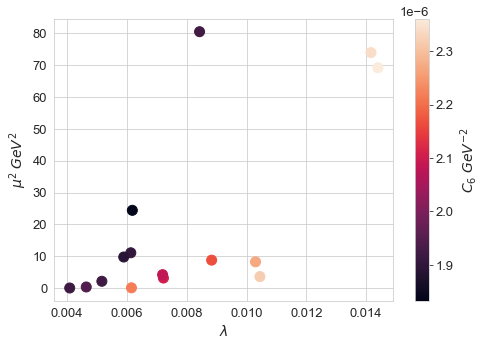

In [21]:
og_array = np.loadtxt('param34.txt').reshape(-1,3)

mu, lam, Lam = og_array[:,0], og_array[:,1], og_array[:,2]

plt.figure(figsize=(7,5), tight_layout=True)
plt.scatter(lam, mu**2, c=1/(Lam**2), s = 100)
plt.xlabel('$\lambda$')
plt.ylabel('$\mu^2 \: GeV^2$')
plt.colorbar().set_label('$C_6$ $GeV^{-2}$')

#plt.savefig('param3.eps')

In [ ]:
#Random tensting if 

phi = np.linspace(0, 300,100)

mu, lam, Lam = og_array[5]

plt.plot(phi/246, np.vectorize(v_eff)(phi, mu, lam, Lam)/246**4)

print(mu, lam, Lam)
print(np.sqrt(d2_v(mu,lam,Lam)))
print(phi_min(mu,lam,Lam))
print(optimize.fmin(v_eff,300, args=(mu,lam,Lam), disp=0)[0])